In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense,Input,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


from f1optimization_faron import get_best_prediction
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , log_loss

from datetime import datetime
from tqdm import tqdm
import pickle
import os

In [2]:
data = pd.HDFStore("Data_v2.h5")

In [3]:
train_data = data['train']
test_data  = data['test']

Utility Functions

In [30]:
def display_target_distribution(y_train, y_val):

  """
  Display target distribution in train and validation data
  """
  _, train_label_counts = np.unique(y_train, return_counts=True)
  _, val_label_counts = np.unique(y_val, return_counts=True)


  width = 0.35  # the width of the bars
  x = np.arange(2)
  fig, ax = plt.subplots(figsize=(12,6))
  rects1 = ax.bar(x - width/2, train_label_counts, width, label='Train')
  rects2 = ax.bar(x + width/2, val_label_counts, width, label='validation')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Number of datapoints')
  ax.set_title('Distribution of the Output Variable')
  ax.set_xticks(x)
  ax.set_xticklabels([0,1])
  ax.legend()
  plt.show()

def random_split(test_size = 0.1):

  """
  Split data randomly into train and validation data 
  """
  train_y = train_data['reordered'].values.tolist()
  train_x = train_data.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  # since there are Millions of data ,we are taking 10% of data in test set , 
  X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.1, random_state = 42)

  #display distribution of data
  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)

def split_by_user(test_size = 0.1):
  
  #split on users
  sampled_users = train_data['user_id'].sample(n=int(0.1 * train_data['user_id'].nunique()), random_state=42,replace=False).reset_index()
  val = train_data[train_data['user_id'].isin(sampled_users['user_id'].tolist())]
  train = train_data[~train_data['user_id'].isin(sampled_users['user_id'].tolist())]

  y_train = train['reordered'].values.tolist()
  X_train = train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  y_val = val['reordered'].values.tolist()
  X_val = val.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)
def model_stats(predict_y,y_val):# Plot confusion Matrix

  """
  Display model statistics such as accuracy , precision score and confusion matrix
  """

  predict_y =np.array(predict_y>0.5,dtype=int).reshape(-1,).tolist()
  cm = confusion_matrix(y_val, predict_y)
  sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
  plt.show()
  print("Accuracy :",accuracy_score(y_val, predict_y))
  print("Precision :",precision_score(y_val, predict_y))


In [5]:
def getscores_on_testdata(model = None ,scaler = None, model_type = 'xgb', val_file = "Data_v2.h5"):
    """
    Returns product list for every order-ID which maximizes F1-score
    
    Parameters
    ----------
    model      : The default is None.
                 Trained model is passed here  
    model_type : The default is xgb
                 Identifier to deal with both sgb and catboost models
    val_file   : The default is Data_v2.h5
                 Path of dataset is passed
    Returns
    -------
    test_products : Dataframe object
                  This dataframe contains orderID, productID's(string)

    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    
    if model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()
    
    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred
    
    #create a dataframe with orderID and list of all possible productID's
    test_products = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
    
    #collect all probs in a single list for each OrderID
    probs = test_data.groupby(['order_id'])['reordered'].apply(list).reset_index()
    test_products['probs'] = probs['reordered']

    #run faron's optimization code to get most probable set of products which might be reordered
    products = []
    for i in tqdm(test_products.index):
        prods = get_best_prediction(test_products.iloc[i]['product_id'], test_products.iloc[i]['probs'], None)
        products.append(prods)

    test_products['products']= products
    
    test_products['order_id'] = test_products['order_id'].apply(int)
    test_products.drop(['product_id','probs'], axis = 1, inplace = True)
   
    return test_products

In [6]:
def convert_to_string(row):
    """
    convert series value to ist of strings
    """
    list_string = list(map(str, row.tolist())) # convert series > list > list of strings
    return " ".join(list_string)

def globl_threshold_products(model = None, scaler = None, model_type = 'xgb', val_file="Data_v2.h5"):

    """
    Get all products above threshold and join them
    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()

    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred

    #create a dataframe wiith unique order id
    df = pd.DataFrame({'order_id':test_data['order_id'].unique()})

    # 3 best threshold values based on multiple runs
    for i, thresh in enumerate([0.18,0.19,0.20]):

      #get all products above threshold and join them 
      test_data_copy = test_data[test_data['reordered']>=thresh].groupby(['order_id'])['product_id'].apply(convert_to_string).reset_index(name = "products")
      
      #create a submission by merging the order_id with test_data_copy
      submission = pd.merge(test_data_copy,df, on = 'order_id', how = 'right')
      submission['order_id'] = submission['order_id'].apply(int)

      # replace empty cells with None , where no product is above threshold probability
      submission = submission.where(pd.notnull(submission), None)

      #save submission file
      submission.to_csv("submission_sample_v8_{}_{}.csv".format(i+1,model_type), index= False)
      print("Generated submission_sample_v8_{}_{}.csv successfully".format(i+1,model_type))


Catboost


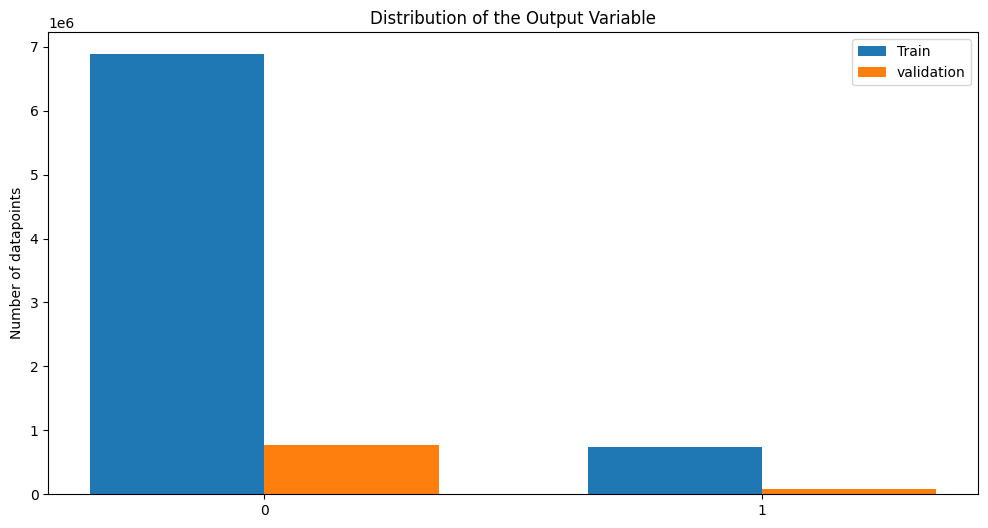

In [7]:
(X_train, y_train),(X_val, y_val) = random_split(test_size = 0.2)

In [8]:
from sklearn.preprocessing import StandardScaler

# fit scaler on training data
scaler = StandardScaler().fit(X_train)

# transforming the data
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

In [9]:
import joblib 
joblib.dump(scaler, 'standrdscaler.pkl') 

['standrdscaler.pkl']

In [15]:
SEED_VALUE = 0
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [16]:
def mlp_model():
    """
    Create mlp model with 4 hidden layers .
    """
    inp = Input(shape =  (28,)) #no of features
    mlp = Dense(256, activation = "relu", kernel_initializer=keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_1')(inp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(128, activation = 'relu', kernel_initializer=keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_2')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(64, activation = 'relu', kernel_initializer=keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_3')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(32, activation = 'relu', kernel_initializer=keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_4')(mlp)
    mlp = Dropout(0.3)(mlp)
    mlp = Dense(1, activation = 'sigmoid', kernel_initializer=keras.initializers.he_normal(seed=SEED_VALUE), name = 'fc_5')(mlp)

    model = Model(inputs = inp, outputs = mlp)
    
    opt = Adam(lr= 0.001)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [17]:
filepath="saved_model/mlp/checkpoint.hdf5"

if not os.path.exists("saved_model/mlp/"):
    os.makedirs("saved_model/mlp/")    

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1)
keras.backend.clear_session()

model = mlp_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 fc_1 (Dense)                (None, 256)               7424      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 fc_2 (Dense)                (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 fc_3 (Dense)                (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

d:\prashant\softwares\Python\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
batch_size = 128
history = model.fit(X_train_norm,np.array(y_train).reshape(-1,1), epochs = 10, validation_data = (X_val_norm,np.array(y_val).reshape(-1,1)), callbacks=[checkpoint, earlystop])

Epoch 1/10
238341/238350 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9051
Epoch 1: val_accuracy improved from -inf to 0.90353, saving model to saved_model/mlp\checkpoint.hdf5
238350/238350 [==============================] - 1228s 5ms/step - loss: 0.2588 - accuracy: 0.9051 - val_loss: 0.2559 - val_accuracy: 0.9035
Epoch 2/10
238345/238350 [============================>.] - ETA: 0s - loss: 0.2584 - accuracy: 0.9052
Epoch 2: val_accuracy improved from 0.90353 to 0.90724, saving model to saved_model/mlp\checkpoint.hdf5
238350/238350 [==============================] - 1243s 5ms/step - loss: 0.2584 - accuracy: 0.9052 - val_loss: 0.2536 - val_accuracy: 0.9072
Epoch 3/10
238339/238350 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9048
Epoch 3: val_accuracy improved from 0.90724 to 0.90783, saving model to saved_model/mlp\checkpoint.hdf5
238350/238350 [==============================] - 1262s 5ms/step - loss: 0.2590 - accuracy: 0.9048 - val_l

In [19]:
saved_model = tf.keras.models.load_model('saved_model/mlp/checkpoint.hdf5')
print("Training Accuracy :{:.2f} %".format(saved_model.evaluate(X_train_norm,np.array(y_train).reshape(-1,1), verbose = 0)[1]*100))
print("Validation Accuracy :{:.2f} %".format(saved_model.evaluate(X_val_norm,np.array(y_val).reshape(-1,1), verbose = 0)[1]*100))


Training Accuracy :90.78 %
Validation Accuracy :90.78 %


In [21]:
predict_y

array([[0.00144693],
       [0.01894163],
       [0.02033764],
       ...,
       [0.39690349],
       [0.06700488],
       [0.20537491]], dtype=float32)

In [20]:
predict_y = saved_model.predict(X_val_norm)
print("logloss on validation data :",log_loss(y_val, predict_y.reshape(-1,).tolist(), labels=[0,1], eps=1e-15))



26484/26484 [==============================] - 119s 4ms/step
logloss on validation data : 0.25061789018918834


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [29]:
pd.Series(np.array(y_val).astype('int')).unique()

array([0, 1])

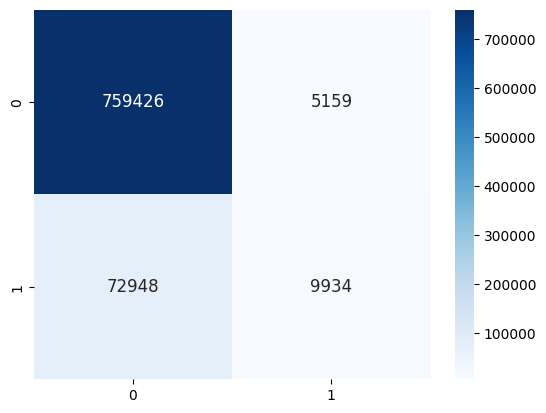

Accuracy : 0.9078347593475616
Precision : 0.6581859139998675


In [31]:
model_stats(predict_y,np.array(y_val).astype('int'))